# Evaluation

The purpose of this notebook is to evaluate a model that will recommend items of clothing to a customer.

Ir order to do this we simulate the process where a customer uploads a photo that will be compared to the images of products a store is currently selling.

The strategy will be to use a neural network already trained and use it to extract a feature representation of all the store images which we will call embeddings. These embeddings will be saved to a file on disk and when a customer uploads a new image the embedding of that image will be extracted, then we will calculate the distances to all images in our store and return the "n" most similar products.

A variety of models and distance metrics are evaluated to find out what provides the best performance.

In [1]:
import os
import sys
import re
import shutil
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches
import matplotlib.image as mpimg
from tqdm import tqdm_notebook
from PIL import Image
import cv2
from scipy.spatial.distance import cdist
%matplotlib inline
pd.options.mode.chained_assignment = None  #disables .loc assignment warning
    
import sys
sys.path.insert(0, "../utils")
from utils import read_image, bbox_corners, crop_image, find_paths, save_embeddings, rank_recommendations
    
#loadded three different models to test which one perfomrs better
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet import MobileNet
from keras.applications.resnet50 import preprocess_input as prep_input_RN50
from keras.applications.vgg16 import preprocess_input as prep_input_VGG16
from keras.applications.mobilenet import preprocess_input as prep_input_MN
from keras.preprocessing import image
#pip install h5py==2.8.0rc1 to disable the h5py warning

Using TensorFlow backend.


# TO REWRITE AFTER COMPLETION
## Selecting the products from the store

In order to obtain a fair evaluation of the algorithm we need to use a similar amount of products that the usual store would have in stock.

Selecting a higher number of products would bias ... 

This is why we decide to select x products for valid and for test...

Given this amount of products per category we want to establish a a series of benchmarks to evaluate the performance of the algorithm

This means sampling down the amount of products (unique id & unique photo).

### Filtering out images that have duplicated categories & duplicated bboxes
Duplicated categories are usually troublesome since it means the same photo has been reused for different products and therefore the quality of each of the product is deemed to be poorer than the usual image a customer would upload. A customer is expected to upload a photo with reasonable quality in terms of lighting, perspective and size.

Some of the photos have duplicated bounding boxes, this is due to the same items appearing more than once in the photo or due to other unknown reasons, to make it simple we will filter these photos out too.

In [2]:
customer_df = pd.read_csv("../customer_df.csv")
retrieval_df = pd.read_csv("../retrieval_df.csv")

In [3]:
#filtering by unique photos
freq_categories = pd.DataFrame(customer_df["photo"].value_counts())
freq_categories = freq_categories[freq_categories["photo"] == 1]
customer_df = customer_df[customer_df["photo"].isin(freq_categories.index)]

print(customer_df.shape)
print(customer_df["category"].value_counts())

(9034, 8)
dresses      5996
tops         1164
footwear      568
outerwear     498
leggings      240
skirts        211
bags          132
eyewear       126
pants          46
belts          43
hats           10
Name: category, dtype: int64


### Joining customer and retrieval & filtering categories
This will discard all images that do not match to customer_df. These are images introduced by the original dataset as extra noise.

Will filter categories to dresses and tops. These categories are selected due to the volume of available images and due to having less noise than other categories.

In [4]:
#merging both datasets to get rid of the retrieval products that do not match
matches_df = customer_df.merge(retrieval_df, how="inner", on="id", suffixes=("_cust", "_retr"))
matches_df = matches_df[matches_df["category_cust"].isin(["dresses", "tops"])]
matches_df.head(3)

,photo_cust,product_cust,category_cust,id,height,left,top,width,photo_retr,product_retr,category_retr
127,16319,54349,dresses,54349_dresses,1431.0,182.0,480.0,1419.0,37491,54349,dresses
128,16319,54349,dresses,54349_dresses,1431.0,182.0,480.0,1419.0,37492,54349,dresses
129,16319,54349,dresses,54349_dresses,1431.0,182.0,480.0,1419.0,37493,54349,dresses


### Building final dataframes for customer & retrieval and list of paths to these photos

In [5]:
np.random.seed(2018) #select how many photos in each set, randomly shuffled
#matched items
perm = np.random.permutation(matches_df['product_cust'].unique()) #permutes list of photos randomly
split = int(len(matches_df['product_cust'].unique())*0.5)
valid, test = np.split(perm, [split])
valid_df = matches_df[matches_df['product_cust'].isin(valid)]
test_df = matches_df[matches_df['product_cust'].isin(test)]

In [6]:
print("Validation photos:")
print(" - Customer")
print("    Dresses:", len(valid_df[valid_df['category_cust'] == 'dresses']['photo_cust'].unique()))
print("    Tops:   ", len(valid_df[valid_df['category_cust'] == 'tops']['photo_cust'].unique()))
print(" - Retrieval")
print("    Dresses:", len(valid_df[valid_df['category_cust'] == 'dresses']['photo_retr'].unique()))
print("    Tops:   ", len(valid_df[valid_df['category_cust'] == 'tops']['photo_retr'].unique()))

Validation photos:
 - Customer
    Dresses: 2950
    Tops:    583
 - Retrieval
    Dresses: 5826
    Tops:    1518


In [7]:
print("Test photos:")
print(" - Customer")
print("    Dresses:", len(test_df[test_df['category_cust'] == 'dresses']['photo_cust'].unique()))
print("    Tops:   ", len(test_df[test_df['category_cust'] == 'tops']['photo_cust'].unique()))
print(" - Retrieval")
print("    Dresses:", len(test_df[test_df['category_cust'] == 'dresses']['photo_retr'].unique()))
print("    Tops:   ", len(test_df[test_df['category_cust'] == 'tops']['photo_retr'].unique()))

Test photos:
 - Customer
    Dresses: 3046
    Tops:    581
 - Retrieval
    Dresses: 5863
    Tops:    1566


### Copying photos to new directories

In [8]:
original_dataset_path = "../photos_resized"

for step in zip([valid_df , test_df], ["validation", "test"]):
    photos_list_cust = step[0]["photo_cust"].unique().tolist()
    photos_list_cust = [str(photo) + ".jpg" for photo in photos_list_cust]

    photos_list_retr = step[0]["photo_retr"].unique().tolist()
    photos_list_retr = [str(photo) + ".jpg" for photo in photos_list_retr]

    output_path = os.path.join("..", "photos_evaluation", step[1])
    if not os.path.exists(output_path):
        os.makedirs(output_path, exist_ok=True)
        os.makedirs(os.path.join(output_path, "customer"))
        os.makedirs(os.path.join(output_path, "retrieval"))

    print("Creating customer " + step[1] + " images")
    for photo in tqdm_notebook(photos_list_cust):
        shutil.copy(os.path.join(original_dataset_path, photo), os.path.join(output_path, "customer", photo))

    print("Creating retrieval " + step[1] + " images")
    for photo in tqdm_notebook(photos_list_retr):
        shutil.copy(os.path.join(original_dataset_path, photo), os.path.join(output_path, "retrieval", photo))

Creating customer validation images



Creating retrieval validation images



Creating customer test images



Creating retrieval test images


In [8]:
valid_df_cust = customer_df[customer_df['photo'].isin(valid_df["photo_cust"].unique())]
valid_df_retr = retrieval_df[retrieval_df['photo'].isin(valid_df["photo_retr"].unique())]

test_df_cust = customer_df[customer_df['photo'].isin(test_df["photo_cust"].unique())]
test_df_retr = retrieval_df[retrieval_df['photo'].isin(test_df["photo_retr"].unique())]

In [9]:
#CRITICAL SO IMAGES ARE IN SAME ORDER AS EMBEDDINGS FILE
valid_df_retr = valid_df_retr.sort_values(by="photo")
test_df_retr = test_df_retr.sort_values(by="photo")

In [10]:
#this is how many distint products we have in reality, the more photos we have of each the better though
print("Number of photos/embeddings in store", valid_df_retr["photo"].unique().shape[0])
print(valid_df_retr.drop_duplicates(subset=["id"])["category"].value_counts())
print("Number of matches: ", valid_df.shape[0])

Number of photos/embeddings in store 7344
dresses    1397
tops        395
Name: category, dtype: int64
Number of matches:  14600


In [11]:
#this is how many distint products we have in reality, the more photos we have of each the better though
print("Number of photos/embeddings in store", test_df_retr["photo"].unique().shape[0])
print(test_df_retr.drop_duplicates(subset=["id"])["category"].value_counts())
print("Number of matches: ", test_df.shape[0])

Number of photos/embeddings in store 7429
dresses    1387
tops        410
Name: category, dtype: int64
Number of matches:  15035


As seen above, in validation we have:
- 1397 dresses and 395 tops, these are unique products, however there usually are more than 1 photo per product.
- 14600 total photos, the number of vectors in the database will be equal.
- 14600 matches, since we can have a customer photo matching more than one retrieval photo and we can also have different photos in customer from the same product.

## Creating embeddings

- We will start by chosing an already trained neural network and removing the bottom layers since our intention is to use it for feature extraction and not for classification. For this purpose we will start with VGG16 due to its popularity and the small ouput when doing feature extraction (512 dimensions)
- Then we will extract features for each of the images from the specified retrieval directory and save it to disk to keep us from doing this process every time.
- Once this file is created we load it up so we can start comparing new images to the retrieval images.

In [12]:
dataset_path = os.path.join("..", "photos_evaluation")
retrieval_val_path = os.path.join(dataset_path, "validation", "retrieval")

In [13]:
resizing = (250,250)
shape_output = 512
model = VGG16(weights="imagenet", include_top=False, pooling="avg")
preprocess_input = prep_input_VGG16

# include_top=False removes the fully connected layer at the end/top of the network. This allows us to get the feature vector as opposed to a classification.
# pooling='avg' means that global average pooling will be applied to the output of the last convolutional layer, and thus the output of the model will be a 2D tensor.

In [14]:
# # For testing with MobileNet:
# resizing = (224,224)
# shape_output = 1024
# model = MobileNet(input_shape=(224, 224, 3), weights="imagenet", include_top=False, pooling="avg")
# preprocess_input = prep_input_MN

In [15]:
%%time
#Only run the first time so we can compare a customer image to the retrieval images
save_embeddings(retrieval_val_path, "embeddings_val.npy", model, preprocess_input, shape_output, resize=resizing)

100%|██████████████████████████████████████████████████████████████████████████████| 5406/5406 [00:58<00:00, 92.41it/s]


Wall time: 58.9 s


In [14]:
embs_retrieval = np.load("./embeddings_val.npy")

## Visual inspection

The strategy is to use the already loaded function rank_recommendations which works as a K-Neighbors Search algorithm suited for our case.

We create a rank_similar function that orders the retrieval set based on similarity and keeps only the highest ranked image for each product. Note that a product in retrieval may have more than one photo, this is determined by the "id" feature, usually these are photos from different angles and distances, the intention is to use all this photos to increase the performance of the model when matching a customer photo to retrieval and then only take into account the highest ranked image for each product.

Then we create a show_recommend function to allow us to visually inspect images from the customer dataset.

In [15]:
def rank_similar(target_img, customer_df, retrieval_df, rank):
    """ Finds the image id in the customer_df, and ranks all images by similarity keeping only highest match for each product.    
    Returns retrieval_df ranked and the rank of the matching product"""
    
    img_name = re.split("(\\d+)", target_img)[-2]
    target_df = customer_df[customer_df["photo"] == int(img_name)] #finds image name
    target_id = target_df["id"].unique().tolist()[0] #finds its image id
    
    retrieval_ranked = retrieval_df.iloc[rank] #ranks based on similarity
    retrieval_ranked = retrieval_ranked.drop_duplicates(subset=["id"], keep="first") #ensures only the best match for each product is taken into account
    retrieval_ranked = retrieval_ranked.reset_index(drop=True) #resets index
    same_image_rank = retrieval_ranked[retrieval_ranked["id"] == target_id].index.values.tolist() #extracts index positions for matching product
    return same_image_rank, retrieval_ranked

def show_image(img_array, img_path=None, customer_df=None, title="Image", bbox=False):
    """ Helper function to plot images given an array and optionally plot the bbox"""
    
    fig,ax = plt.subplots(1, figsize=(5,5))
    ax.imshow(img_array)
    plt.title(title)
    plt.axis("off")
    
    if bbox == True:
        left, top, width, height = bbox_corners(img_path, customer_df)
        rect = patches.Rectangle(xy=(left,top),width=width,height=height,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    plt.show()

def show_recommend(top_n, dataset_path, img_path, customer_df, retrieval_ranked, resize, bbox=True):
    """ Shows customer images before and after cropping and the "top_n" retrieval recommendations for visual inspection"""
    
    img_array = read_image(target_img)
    show_image(img_array, img_path, customer_df, title = "User image", bbox=bbox)
    if bbox==True:
        cropped = crop_image(img_path, customer_df, resize=resize)
        show_image(cropped, title="Cropped image")
    
    img_paths = retrieval_ranked['photo'][:top_n]
    print("Top {} similar images".format(top_n))
    
    fig = plt.figure(figsize=(20,20))
    gs = gridspec.GridSpec(1, len(img_paths))
    for n, i in enumerate(img_paths):
        ax = fig.add_subplot(gs[0, n])
        recomend_path = os.path.join(dataset_path, str(i)+".jpg")
        ax.imshow(mpimg.imread(recomend_path))
        ax.axis("off")
    plt.show()

In [16]:
#random sample picks for visual evaluation on below cell, just change the .jpg number for one of these
valid_df_cust.sample(10)["photo"]

6606      9005
935         72
1211      2686
1709     16130
1449     18221
11665     7097
29004    17292
6574     17736
9866      9973
9312      3647
Name: photo, dtype: int64

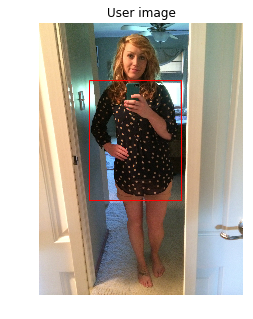

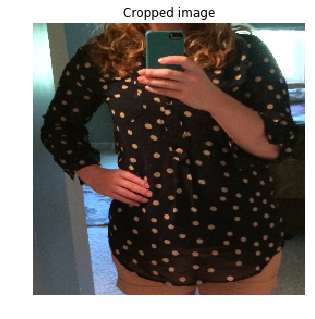

Top 10 similar images


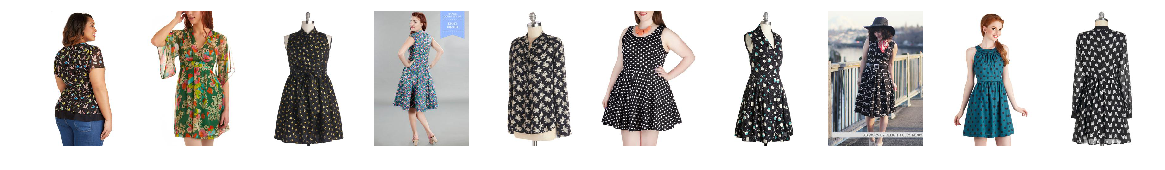

Same images ranked on indices: [449]
Wall time: 1.91 s


In [19]:
%%time
target_img = "../photos_evaluation/validation/customer/9005.jpg"
rank = rank_recommendations(target_img, embs_retrieval, model, preprocess_input,
                            resize=resizing, customer_df=valid_df_cust)

top_n = 10
same_image_rank, retrieval_ranked = rank_similar(target_img, valid_df_cust, valid_df_retr, rank)
show_recommend(top_n, retrieval_val_path, target_img, valid_df_cust, retrieval_ranked, resize=resizing)
print("Same images ranked on indices: {}".format(same_image_rank))

## Measuring model performance

Once we have created an embeddings file from which the most "n" similiar images are returned we need to measure how this process is performing.  
This score will allow us to make improvements in order to find the best parameters and methods.

For the evaluation we will only use customer photos, and each one of them will be compared with the retrieved photos. As a result obtain a rank starting from the most similar photo. Then we will define a K parameter that will set the top k images from the returned rank.

To **evaluate** the model the the following method will be used:
   - Accuracy@K: total number of positive cases / total number of cases
   
To **improve** the model accuracy the following hyperparameters will be fine-tuned:
   - Distance methods: euclidean, cosine, chebyshev
   - Pre-Trained models: VGG16, ResNet50, MobileNet

In [20]:
def evaluate(customer_df, retrieval_df, embs_retrieval, k_list, val_test, model, preprocessing, resize=resizing, method="cosine"):
    
    customer_paths = [os.path.join("..", "photos_evaluation", val_test, "customer", str(img) + ".jpg")
                      for img in customer_df["photo"].tolist()] #full path to each photo
    positives = {"dresses": np.zeros((1, len(k_list)))[0],
                 "tops": np.zeros((1, len(k_list)))[0],
                 } #holds number of matches within "k" for each value of k_list for both dresses and tops
    accuracy_all = {"dresses": np.zeros((1, len(k_list)))[0],
                 "tops": np.zeros((1, len(k_list)))[0],
                 } #holds the accuracy for each value of k_list for both dresses and tops
    
    with tqdm_notebook(total=len(customer_paths)) as pbar:    
        for n, customer_path in enumerate(customer_paths):
            photo_name = re.split("(\\d+)", customer_path)[-2] #finding photo name
            image_customer = customer_df[customer_df["photo"] == int(photo_name)] #finding photo id
            image_id = image_customer['id'].tolist()[0] #always same id even if more than >1 rows
            image_category = image_customer["category"].tolist()[0] #finding photo category
            rank = rank_recommendations(customer_path, embs_retrieval, model, preprocessing,
                                        resize=resize, customer_df=customer_df, method=method)
            
            for i, k in enumerate(k_list):
                retrieval_ranked = retrieval_df.iloc[rank] #retrieval ranked
                retrieval_ranked = retrieval_ranked.drop_duplicates(subset=["id"], keep="first") #ensures only the best match for each item is taken into account
                retrieval_ranked_list = retrieval_ranked["id"].tolist()[:k] #takes list of top "k" products

                if image_id in retrieval_ranked_list: #if the product from the customer img matches retrieval_ranked_list we add 1 to the zeros matrix
                    positives[image_category][i] += 1
            pbar.update(1)
        
        for i, k in enumerate(k_list): #iterates over levels of k
            print("****************** Accuracy at {} ******************".format(k))
            for cat in positives.keys(): #iterates over categories
                total_cat = customer_df[customer_df["category"] == cat].shape[0] #total images for each category
                
                accuracy = positives[cat][i] / total_cat #accuracy for each value of k_list
                accuracy_all[cat][i] = accuracy*100
                print("{}: {:.3f}%".format(cat, accuracy*100))
    return accuracy_all

### Fine-tuning: Distances

In [32]:
%%time
distances = ["euclidean", "cosine", "chebyshev"]
k = [5,10,20,30,40,50]
acc_distances = {}

for distance in distances:
    print("Calculating {} distance\n".format(distance))
    acc = evaluate(valid_df_cust, valid_df_retr, embs_retrieval, k, "validation", model,
                   preprocess_input, resize=resizing, method=distance)
    acc_distances[distance] = acc

Calculating euclidean distance



****************** Accuracy at 5 ******************
dresses: 31.257%
tops: 31.287%
****************** Accuracy at 10 ******************
dresses: 39.465%
tops: 36.040%
****************** Accuracy at 20 ******************
dresses: 48.663%
tops: 46.931%
****************** Accuracy at 30 ******************
dresses: 53.793%
tops: 52.673%
****************** Accuracy at 40 ******************
dresses: 58.007%
tops: 56.436%
****************** Accuracy at 50 ******************
dresses: 61.598%
tops: 60.000%

Calculating cosine distance



****************** Accuracy at 5 ******************
dresses: 34.152%
tops: 33.465%
****************** Accuracy at 10 ******************
dresses: 43.459%
tops: 42.376%
****************** Accuracy at 20 ******************
dresses: 54.379%
tops: 53.267%
****************** Accuracy at 30 ******************
dresses: 61.414%
tops: 59.802%
****************** Accuracy at 40 ******************
dresses: 66.215%
tops: 64.554%
****************** Accuracy at 50 ******************
dresses: 69.329%
tops: 67.129%

Calculating chebyshev distance



****************** Accuracy at 5 ******************
dresses: 6.999%
tops: 7.129%
****************** Accuracy at 10 ******************
dresses: 10.187%
tops: 11.881%
****************** Accuracy at 20 ******************
dresses: 14.511%
tops: 15.050%
****************** Accuracy at 30 ******************
dresses: 17.332%
tops: 16.634%
****************** Accuracy at 40 ******************
dresses: 20.007%
tops: 18.614%
****************** Accuracy at 50 ******************
dresses: 22.389%
tops: 20.594%

Wall time: 24min 54s


In [33]:
joblib.dump(acc_distances, "acc_distances.pkl") #saving accuracy for each distance and category on a file

['acc_distances.pkl']

In [22]:
acc_distances = joblib.load("acc_distances.pkl")

In [35]:
col_names = ["acc@5", "acc@10", "acc@20", "acc@30", "acc@40", "acc@50"]

df_dresses = pd.DataFrame(acc_distances).T["dresses"]
df_dresses = pd.DataFrame(df_dresses.values.tolist(), index=df_dresses.index, columns=col_names)

df_tops = pd.DataFrame(acc_distances).T["tops"]
df_tops = pd.DataFrame(df_tops.values.tolist(), index=df_dresses.index, columns=col_names)

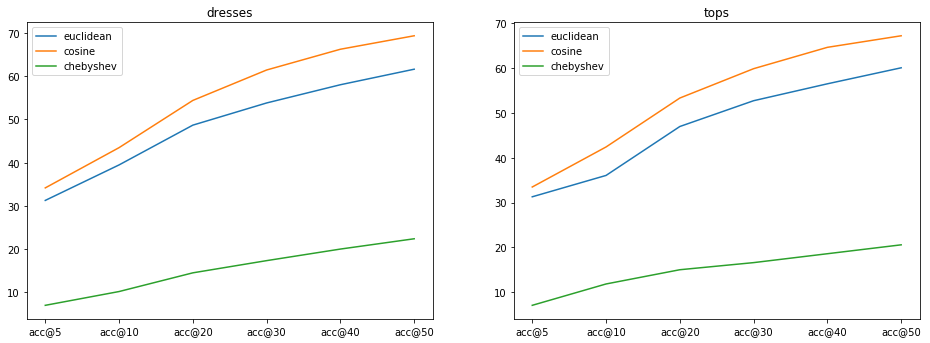

In [39]:
fig = plt.figure(figsize=(16,12))
plt.subplot(2, 2, 1)

plt.plot(col_names, df_dresses.T["euclidean"])
plt.plot(col_names, df_dresses.T["cosine"])
plt.plot(col_names, df_dresses.T["chebyshev"])
plt.legend()
plt.title("dresses")

plt.subplot(2, 2, 2)
plt.plot(col_names, df_tops.T["euclidean"])
plt.plot(col_names, df_tops.T["cosine"])
plt.plot(col_names, df_tops.T["chebyshev"])
plt.legend()
plt.title("tops")
plt.show()

### Fine-tuning: models

In [40]:
nn_VGG16 = VGG16(weights="imagenet", include_top=False, pooling="avg")
nn_Mobile = MobileNet(input_shape=(224, 224, 3), weights="imagenet", include_top=False, pooling="avg")
nn_ResNet50 = ResNet50(weights="imagenet", include_top=False, pooling="avg")

In [48]:
%%time
k = [5,10,20,30,40,50]
distance = "cosine"
models = [nn_VGG16, nn_ResNet50, nn_Mobile]
prep_inputs = [prep_input_VGG16, prep_input_RN50, prep_input_MN]
shapes = [512, 2048, 1024]
resizings = [(250,250), (250,250), (224,224)]

acc_models = {}

for n in zip(models, prep_inputs, shapes, resizings):
    model, preprocess_input, shape, resizing = n[0], n[1], n[2], n[3]
    print("Calculating {}\n".format(model.name))
    save_embeddings(os.path.join(dataset_path, "validation", "retrieval"), file_name="embeddings_val.npy", 
                model=model, preprocessing=preprocess_input, shape=shape, resize=resizing)
    embs_retrieval = np.load("./embeddings_val.npy")
    acc = evaluate(valid_df_cust, valid_df_retr, embs_retrieval, k, "validation", model,
                   preprocess_input, resize=resizing, method=distance)
    acc_models[model.name] = acc

Calculating vgg16



100%|██████████████████████████████████████████████████████████████████████████████| 5406/5406 [02:54<00:00, 30.99it/s]


****************** Accuracy at 5 ******************
dresses: 21.656%
tops: 28.911%
****************** Accuracy at 10 ******************
dresses: 29.498%
tops: 36.436%
****************** Accuracy at 20 ******************
dresses: 39.575%
tops: 45.347%
****************** Accuracy at 30 ******************
dresses: 45.841%
tops: 52.079%
****************** Accuracy at 40 ******************
dresses: 51.081%
tops: 55.842%
****************** Accuracy at 50 ******************
dresses: 55.258%
tops: 60.396%

Calculating resnet50



100%|██████████████████████████████████████████████████████████████████████████████| 5406/5406 [03:19<00:00, 27.12it/s]


****************** Accuracy at 5 ******************
dresses: 35.544%
tops: 33.861%
****************** Accuracy at 10 ******************
dresses: 44.852%
tops: 41.782%
****************** Accuracy at 20 ******************
dresses: 56.174%
tops: 51.287%
****************** Accuracy at 30 ******************
dresses: 61.561%
tops: 55.644%
****************** Accuracy at 40 ******************
dresses: 66.654%
tops: 60.396%
****************** Accuracy at 50 ******************
dresses: 70.099%
tops: 62.970%

Calculating mobilenet_1.00_224



100%|██████████████████████████████████████████████████████████████████████████████| 5406/5406 [01:20<00:00, 67.41it/s]


****************** Accuracy at 5 ******************
dresses: 34.152%
tops: 33.465%
****************** Accuracy at 10 ******************
dresses: 43.459%
tops: 42.376%
****************** Accuracy at 20 ******************
dresses: 54.379%
tops: 53.267%
****************** Accuracy at 30 ******************
dresses: 61.414%
tops: 59.802%
****************** Accuracy at 40 ******************
dresses: 66.215%
tops: 64.554%
****************** Accuracy at 50 ******************
dresses: 69.329%
tops: 67.129%

Wall time: 36min 40s


In [49]:
joblib.dump(acc_models, "acc_models.pkl") #saving accuracy for each model and category on a file

['acc_models.pkl']

In [50]:
acc_models = joblib.load("acc_models.pkl")

In [51]:
df_dresses = pd.DataFrame(acc_models).T["dresses"]
df_dresses = pd.DataFrame(df_dresses.values.tolist(), index=df_dresses.index, columns=col_names)

df_tops = pd.DataFrame(acc_models).T["tops"]
df_tops = pd.DataFrame(df_tops.values.tolist(), index=df_dresses.index, columns=col_names)

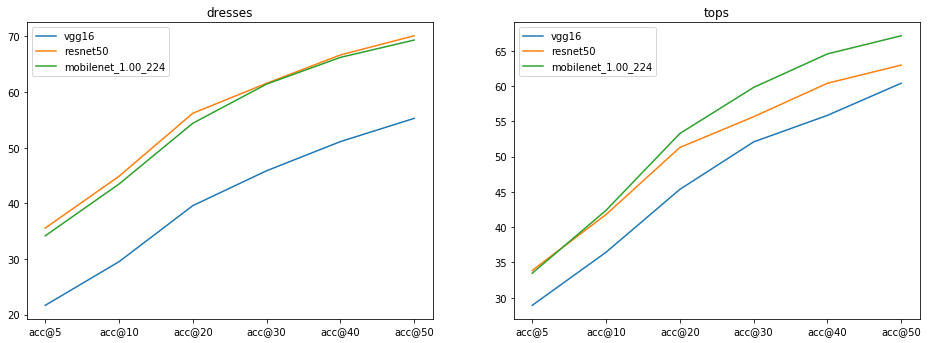

In [53]:
fig = plt.figure(figsize=(16,12))
plt.subplot(2, 2, 1)

plt.plot(col_names, df_dresses.T["vgg16"])
plt.plot(col_names, df_dresses.T["resnet50"])
plt.plot(col_names, df_dresses.T["mobilenet_1.00_224"])
plt.legend()
plt.title("dresses")

plt.subplot(2, 2, 2)
plt.plot(col_names, df_tops.T["vgg16"])
plt.plot(col_names, df_tops.T["resnet50"])
plt.plot(col_names, df_tops.T["mobilenet_1.00_224"])
plt.legend()
plt.title("tops")
plt.show()

### Results
Based on these results we will select the **cosine** method to establish the similarity between a pair of images and the **MobileNet** model.

$$sim(A,B) = cos(\theta) = \frac{A·B}{||A||||B||}$$
<img src="https://i.imgur.com/kC54AQE.png" width="400">

## Placeholder

![idea for network](https://cdn-images-1.medium.com/max/1600/1*ZA6O4-IZwvSmaj5Ddh_ZnA.png)

## Final validation & Test

In [54]:
k = [5,10,20,30,40,50]
distance = "cosine"
model = nn_Mobile
preprocess_input = prep_input_MN
shape = 1024
resizing = (224,224)

In [55]:
#Validation
save_embeddings(os.path.join(dataset_path, "validation", "retrieval"), file_name="embeddings_val.npy", 
                model=model, preprocessing=preprocess_input, resize=resizing, shape=shape)

embs_retrieval = np.load("./embeddings_val.npy")
acc_valid = evaluate(valid_df_cust, valid_df_retr, embs_retrieval, k, "validation", model,
                     preprocess_input, resize=resizing, method=distance)
joblib.dump(acc_valid, "acc_valid.pkl") #saving accuracy for each category on a file
# acc_valid = joblib.load("acc_valid.pkl")

****************** Accuracy at 5 ******************
dresses: 34.152%
tops: 33.465%
****************** Accuracy at 10 ******************
dresses: 43.459%
tops: 42.376%
****************** Accuracy at 20 ******************
dresses: 54.379%
tops: 53.267%
****************** Accuracy at 30 ******************
dresses: 61.414%
tops: 59.802%
****************** Accuracy at 40 ******************
dresses: 66.215%
tops: 64.554%
****************** Accuracy at 50 ******************
dresses: 69.329%
tops: 67.129%



['acc_valid.pkl']

In [57]:
#Test
save_embeddings(os.path.join(dataset_path, "test", "retrieval"), file_name="embeddings_test.npy", 
                model=model, preprocessing=preprocess_input, resize=resizing, shape=shape)

embs_retrieval = np.load("./embeddings_test.npy")
acc_test = evaluate(test_df_cust, test_df_retr, embs_retrieval, k, "test", model,
                    preprocess_input, resize=resizing, method=distance)
joblib.dump(acc_test, "acc_test.pkl") #saving accuracy for each category on a file
# acc_test = joblib.load("acc_test.pkl")

100%|██████████████████████████████████████████████████████████████████████████████| 5420/5420 [01:19<00:00, 68.28it/s]


C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (99272481 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2514: DecompressionBombWarning: Image size (123871510 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


****************** Accuracy at 5 ******************
dresses: 37.409%
tops: 35.031%
****************** Accuracy at 10 ******************
dresses: 46.507%
tops: 44.603%
****************** Accuracy at 20 ******************
dresses: 56.259%
tops: 54.786%
****************** Accuracy at 30 ******************
dresses: 61.790%
tops: 60.692%
****************** Accuracy at 40 ******************
dresses: 65.684%
tops: 65.580%
****************** Accuracy at 50 ******************
dresses: 68.886%
tops: 68.432%



['acc_test.pkl']

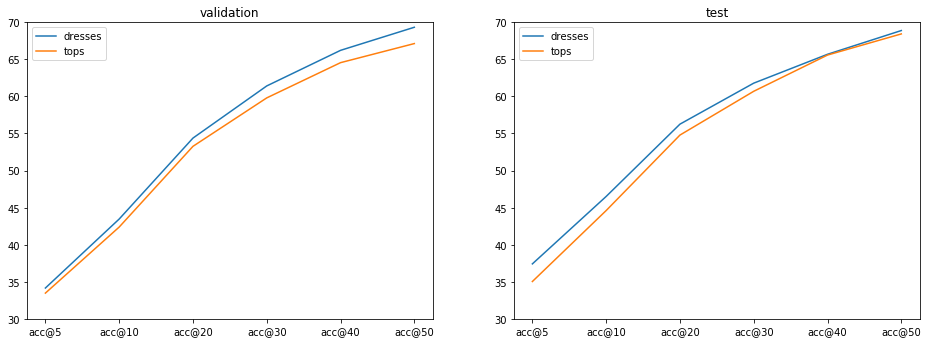

In [60]:
df_valid = pd.DataFrame(acc_valid, index=col_names)
df_test = pd.DataFrame(acc_test, index=col_names)

fig = plt.figure(figsize=(16,12))
plt.subplot(2, 2, 1)

plt.plot(col_names, df_valid["dresses"])
plt.plot(col_names, df_valid["tops"])
plt.ylim((30,70))
plt.legend()
plt.title("validation")

plt.subplot(2, 2, 2)
plt.plot(col_names, df_test["dresses"])
plt.plot(col_names, df_test["tops"])
plt.ylim((30,70))

plt.legend()
plt.title("test")
plt.show()